### This notebok uses our latest findings in an attempt to find equations of motion for a reduced space.

In [2]:
import pysindy as ps
import numpy as np
from CAE_NIF import CAE
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from tensorflow.keras import layers, models, optimizers
import imageio
import time
import os
import tempfile

In [3]:
val = np.load('States1p0.01dt4000.npy')
#dat = np.load('Frames.npy')
#print(dat.shape)
print(val.shape)

(4000, 2000, 1)


In [4]:
lis = []
lis.append(val)
li = np.array(lis)
li = li.reshape(4000,2000,1)
#np.save('StatesGP0.01dt4000', li)
x = np.linspace(-10,10,2000)

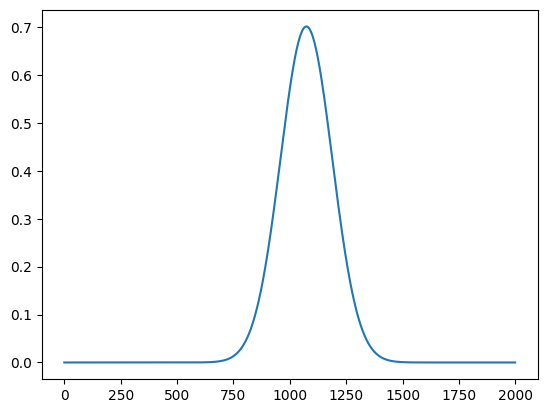

In [5]:
plt.plot(li[:][3999])

In [6]:
# for i in range(0,len(val),5):
#     plt.plot(x, val[i][:], label='Differencial')  
#     #plt.plot(x, dat[i][:], label='Explicit')
#     plt.title(f'State {i+1}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.grid(True)
#     plt.ylim(-0.1,1.2)
#     plt.legend()
    
#     # Display the plot in the notebook
#     display(plt.gcf())
#     clear_output(wait=True)
#     time.sleep(0.000001)  # Add a short delay to slow down the animation

#     # Clear the previous plot to avoid overlapping
#     plt.clf()

### Encoding

The first step in the process is to encode the information of the oscillator into a smaller dimension, usually 2 or 3. This can be accomplished by using the written CAE_NIF.py file.

In [7]:
autoencoder = CAE(2,2000)
optimizer = optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, name='Adam')
autoencoder.compile(optimizer=optimizer, loss='mse')
# Train the autoencoder model
autoencoder.fit(li, li, epochs=20, batch_size=8)

Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 2/20
500/500 [==============================] - 2s 3ms/step - loss: 2.6456e-05
Epoch 3/20
500/500 [==============================] - 2s 3ms/step - loss: 2.6490e-05
Epoch 4/20
500/500 [==============================] - 2s 3ms/step - loss: 6.3767e-05
Epoch 5/20
500/500 [==============================] - 2s 3ms/step - loss: 8.0216e-06
Epoch 6/20
500/500 [==============================] - 2s 4ms/step - loss: 6.5684e-05
Epoch 7/20
500/500 [==============================] - 2s 3ms/step - loss: 1.7846e-05
Epoch 8/20
500/500 [==============================] - 2s 3ms/step - loss: 4.1572e-05
Epoch 9/20
500/500 [==============================] - 2s 3ms/step - loss: 1.1531e-05
Epoch 10/20
500/500 [==============================] - 2s 3ms/step - loss: 1.4884e-05
Epoch 11/20
500/500 [==============================] - 2s 3ms/step - loss: 9.9501e-05
Epoch 12/20
500/500 [==============================] - 2s 3ms/step 

In [8]:
#autoencoder.fit(data, data, epochs=100, validation_data=(data,data), batch_size=8)

In [9]:
predict = autoencoder.predict_on_batch(li)

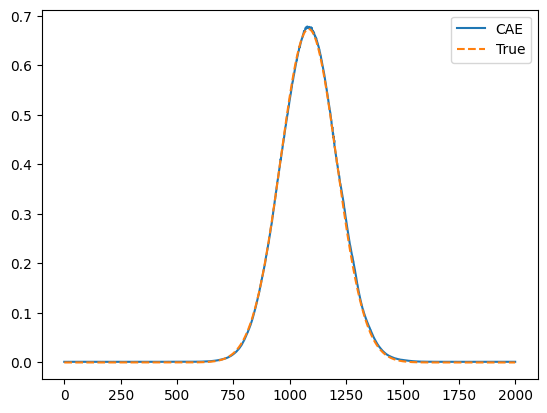

In [10]:
t = 2099
plt.plot(predict[t], label="CAE")
plt.plot(li[t], label="True", linestyle="--")
plt.legend()
plt.show()

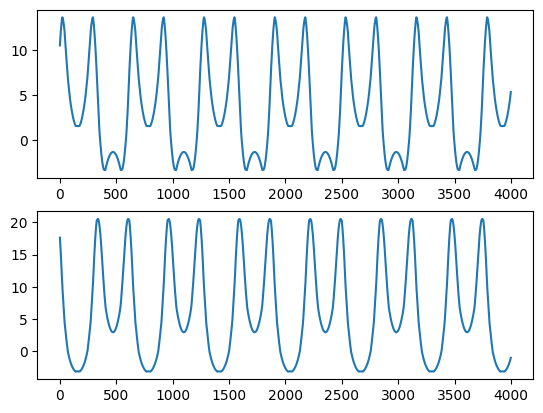

In [11]:
latent = autoencoder.encode(li)
fig, axs = plt.subplots(2,1,)
#plt.plot(latent[:,0])
axs[0].plot(latent[:,0])
axs[1].plot(latent[:,1])
#axs[2].plot(latent[:,2])
#axs[3].plot(latent[:,3])

### Interpolation

The latent space that is received after the autoencoder can often times have quite a bit of numerical noise. To countetact this, interpolation can be used.

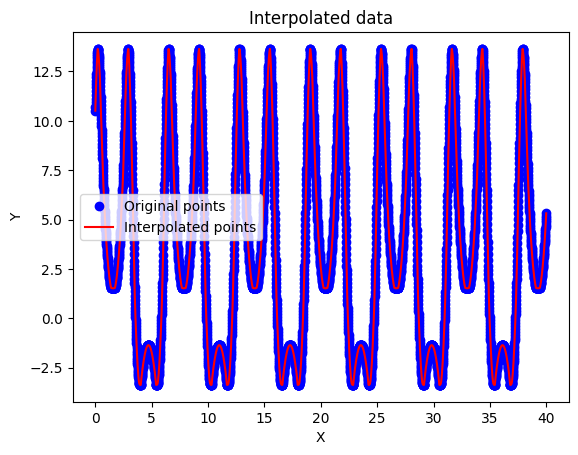

In [1303]:
NT=4000
lat_long = np.zeros([NT,latent.shape[1]])
for i in range(latent.shape[1]):
    t = np.linspace(0, 40, 4000)  # Assuming x values are evenly spaced
    f = interp1d(t, latent[:,i], kind='cubic')
    x_new = np.linspace(0, 40, NT)  # Increase the number of points to 16000 for example
    y_new = f(x_new)
    lat_long[:,i] = y_new
# Plot original data
plt.plot(t, latent[:,0], 'bo', label='Original points')

# Plot interpolated data
plt.plot(x_new, lat_long[:,0], 'r', label='Interpolated points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated data')
#plt.ylim(10,11.5)
plt.show()

To find the equations of motion for the latent space, PySINDy is used. PySINDy u

In [1305]:
def finite_difff(points, time, order=1):
    t = time
    X=points
    finite_diff = np.zeros_like(X)
    if order == 1:
        for i in range(finite_diff.shape[1]):
            for j in range(finite_diff.shape[0]):
                if j < 4:
                    finite_diff[j,i] = (-25/12*X[j,i] + 4*X[j+1,i] -3*X[j+2,i] + 4/3*X[j+3,i] - 1/4*X[j+4,i])/(t[1]-t[0])
                elif j > finite_diff.shape[0]-4:
                    finite_diff[j,i] = (25/12*X[j,i] - 4*X[j-1,i] +3*X[j-2,i] - 4/3*X[j-3,i] + 1/4*X[j-4,i])/(t[1]-t[0])
                else:
                    finite_diff[j,i] = (-1/60*X[j-3,i] + 3/20*X[j-2,i] -3/4*X[j-1,i] + 3/4*X[j+1,i] - 
                                        3/20*X[j+2,i] + 1/60*X[j+3,i])/(t[1]-t[0])
    elif order == 2:
        for i in range(finite_diff.shape[1]):
            for j in range(finite_diff.shape[0]):
                if j < 4:
                    finite_diff[j,i] = (15/4*X[j,i] - 77/6*X[j+1,i] + 107/6*X[j+2,i] - 13*X[j+3,i] + 61/12*X[j+4,i] -5/6*X[j+5,i])/(t[1]-t[0])**order
                elif j > finite_diff.shape[0]-4:
                    finite_diff[j,i] = -(-15/4*X[j,i] + 77/6*X[j-1,i] - 107/6*X[j-2,i] + 13*X[j-3,i] - 61/12*X[j-4,i] + 5/6*X[j-5,i])/(t[1]-t[0])**order
                else:
                    finite_diff[j,i] = (1/90*X[j-3,i] - 3/20*X[j-2,i] + 3/2*X[j-1,i] - 49/18*X[j,i]+ 3/2*X[j+1,i] - 
                                        3/20*X[j+2,i] + 1/90*X[j+3,i])/(t[1]-t[0])**order

    elif order == 3:
        for i in range(finite_diff.shape[1]):
            for j in range(finite_diff.shape[0]):
                if j < 5:
                    finite_diff[j,i] = (-49/8*X[j,i] + 29*X[j+1,i] -461/8*X[j+2,i] + 
                                        62*X[j+3,i] - 307/8*X[j+4,i] + 13*X[j+5,i] - 15/8*X[j+6,i])/(t[1]-t[0])**order
                elif j > finite_diff.shape[0]-5:
                    finite_diff[j,i] = (49/8*X[j,i] - 29*X[j-1,i] +461/8*X[j-2,i] - 
                                        62*X[j-3,i] + 307/8*X[j-4,i] - 13*X[j-5,i] + 15/8*X[j-6,i])/(t[1]-t[0])**order
                else:
                    finite_diff[j,i] = (-7/240*X[j-4,i] + 3/10*X[j-3,i] - 169/120*X[j-2,i] + 61/30*X[j-1,i] + 
                                       -61/30*X[j+1,i] + 169/120*X[j+2,i] - 3/10*X[j+3,i] + 7/240*X[j+4,i])/(t[1]-t[0])**order

    else:
         for i in range(finite_diff.shape[1]):
            for j in range(finite_diff.shape[0]):
                if j < 5:
                    finite_diff[j,i] = (28/3*X[j,i] - 111/2*X[j+1,i] + 142*X[j+2,i] - 1219/6*X[j+3,i] + 
                                        176*X[j+4,i] - 185/2*X[j+5,i] + 82/3*X[j+6,i] - 7/2*X[j+7,i])/(t[1]-t[0])**order
                elif j > finite_diff.shape[0]-5:
                    finite_diff[j,i] = (-28/3*X[j,i] + 111/2*X[j-1,i] - 142*X[j-2,i] + 1219/6*X[j-3,i] - 
                                        176*X[j-4,i] + 185/2*X[j-5,i] - 82/3*X[j-6,i] + 7/2*X[j-7,i])/(t[1]-t[0])**order
                else:
                    finite_diff[j,i] = (7/240*X[j-4,i] - 2/5*X[j-3,i] + 169/60*X[j-2,i] - 122/15*X[j-1,i] + 91/8*X[j,i]
                                       -122/15*X[j+1,i] + 169/60*X[j+2,i] - 2/5*X[j+3,i] + 7/240*X[j+4,i])/(t[1]-t[0])**order
    
        
    return finite_diff

In [1307]:
def finite_diff_old(points, time, order=1):
    t = time
    X=points
    finite_diff = np.zeros_like(X)
    if order == 1:
        for i in range(finite_diff.shape[1]):
            for j in range(finite_diff.shape[0]):
                if j < 4:
                    finite_diff[j,i] = (-25/12*X[j,i] + 4*X[j+1,i] -3*X[j+2,i] + 4/3*X[j+3,i] - 1/4*X[j+4,i])/(t[1]-t[0])
                elif j > finite_diff.shape[0]-4:
                    finite_diff[j,i] = (25/12*X[j,i] - 4*X[j-1,i] +3*X[j-2,i] - 4/3*X[j-3,i] + 1/4*X[j-4,i])/(t[1]-t[0])
                else:
                    finite_diff[j,i] = (-1/60*X[j-3,i] + 3/20*X[j-2,i] -3/4*X[j-1,i] + 3/4*X[j+1,i] - 
                                        3/20*X[j+2,i] + 1/60*X[j+3,i])/(t[1]-t[0])
    return finite_diff

0
1


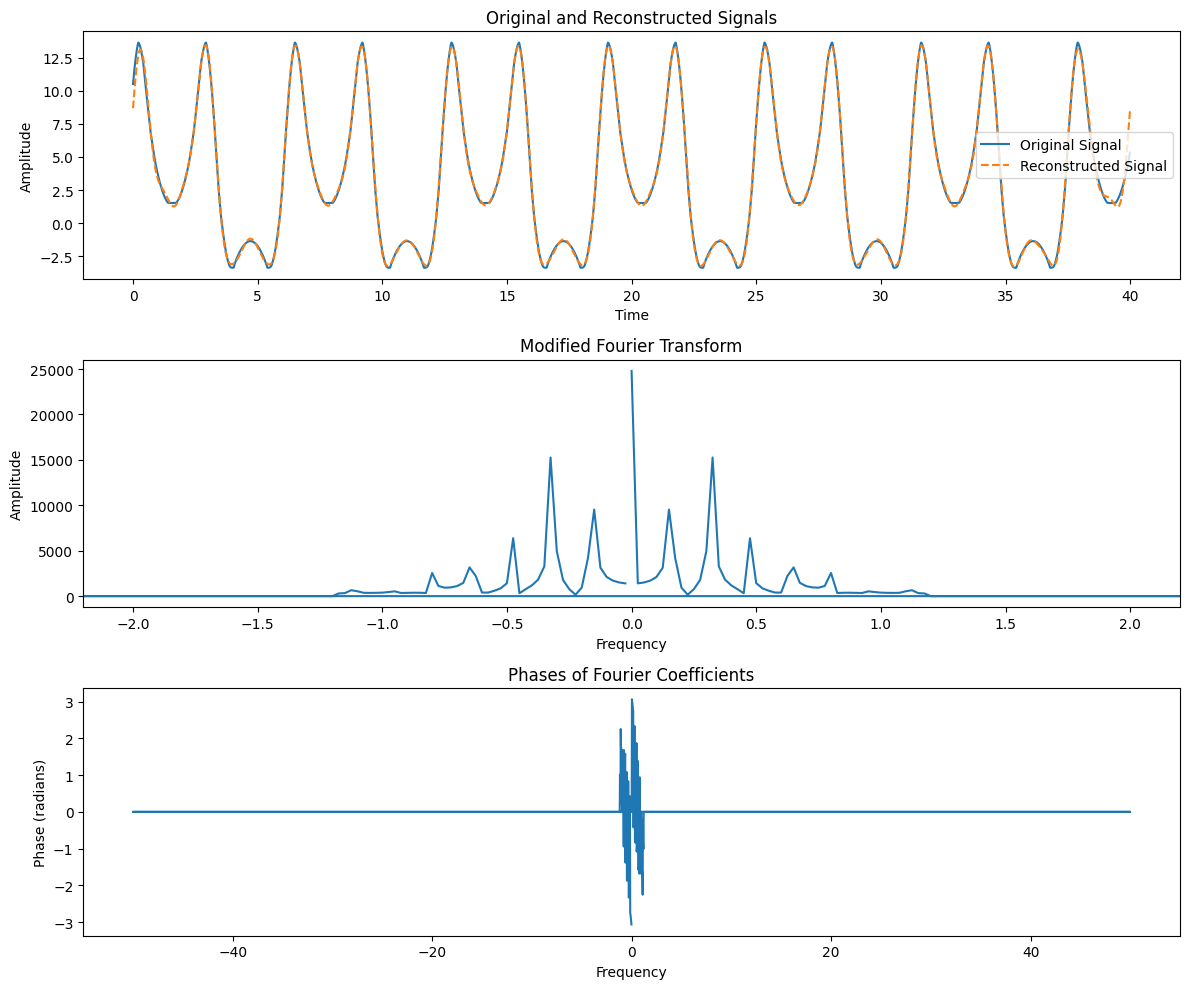

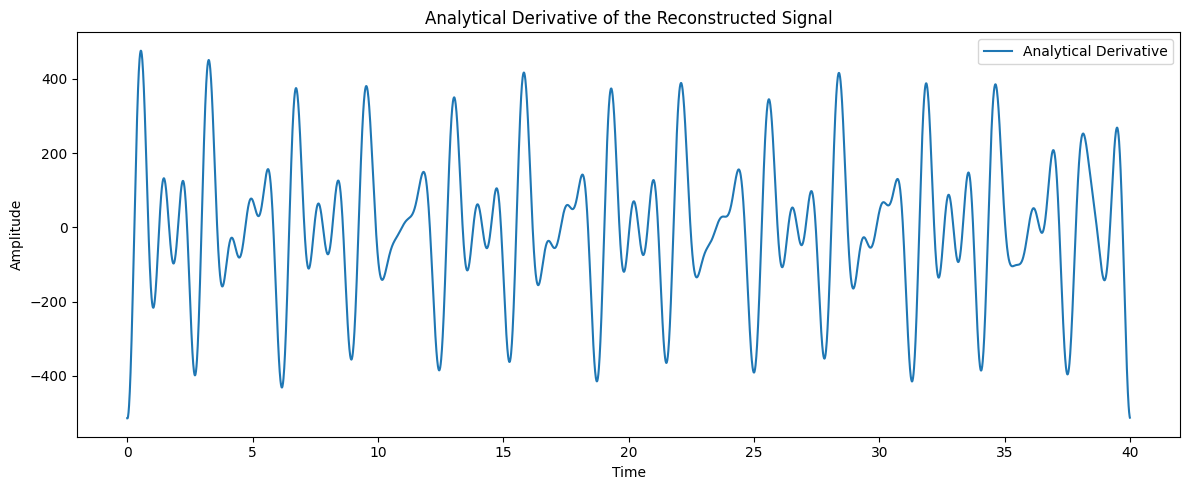

In [1645]:
eq = []
X=lat_long
derivatives = []
finite = None
num_lis = [1.4,0.9,1.2]
for i in range(X.shape[1]):
    print(i)
    # Generate a sample signal
    t = np.linspace(0, 40, X.shape[0], endpoint=False)  # time points from 0 to 40 (exclusive) with 4000 samples
    signal = X[:, i]  # Example signal (replace with your data)
    
    # Compute Fourier transform
    fourier_transform = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), t[1] - t[0])  # compute frequency axis
    
    # Zero out frequencies above 'num' Hz
    num = 1.2
    fourier_transform[np.abs(freqs) > num] = 0
    
    # Extract amplitudes and phases
    amplitudes = np.abs(fourier_transform)
    phases = np.angle(fourier_transform)
    
    # Construct reconstructed signal
    t_large = np.linspace(0, 40, X.shape[0])
    waveform = np.zeros_like(t_large)
    for j in range(len(freqs)):
        amplitude = amplitudes[j]
        phase = phases[j]
        freq = freqs[j]
        waveform += amplitude * np.cos(2 * np.pi * freq * t_large + phase) / X.shape[0]
    
    if i == 0:
        first_one = waveform
    eq.append(waveform)


    for order in range(1, 6):
        derivative_fourier = (2j * np.pi * freqs) ** order * fourier_transform
        
        # Compute the inverse Fourier transform to get the derivative in the time domain
        derivative_signal = np.fft.ifft(derivative_fourier).real
        derivatives.append(derivative_signal)

 

finite = np.array(eq).T
equate = finite

derivative = [item for pair in zip(derivatives[0:int(len(derivatives)/2)], derivatives[-int(len(derivatives)/2):]) for item in pair]


    

# Plotting
plt.figure(figsize=(12, 10))

# Original and Reconstructed signal plot
plt.subplot(3, 1, 1)
plt.plot(t, X[:, 0], label='Original Signal')
plt.plot(t_large, first_one, label='Reconstructed Signal', linestyle='--')
plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Fourier transform plot
plt.subplot(3, 1, 2)
plt.plot(freqs, np.abs(fourier_transform))
plt.title('Modified Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(-num-1, num+1)

# Phase plot
plt.subplot(3, 1, 3)
plt.plot(freqs, phases)
plt.title('Phases of Fourier Coefficients')
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.tight_layout()

# Plot the derivative
plt.figure(figsize=(12, 5))
plt.plot(t, derivatives[2], label='Analytical Derivative')
plt.title('Analytical Derivative of the Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

plt.show()

In [1647]:
def symmetric_moving_average(signal,window_size):
    n = len(signal)
    filtered_signal = np.zeros_like(signal)
    half_window = window_size // 2
    
    for i in range(n):
        for j in range(filtered_signal.shape[1]):
            if i >= half_window and i < n - half_window:
                filtered_signal[i,j] = np.mean(signal[i - half_window:i + half_window,j])
                
            elif 1 < i < half_window:
                filtered_signal[i,j] = np.mean(signal[0:2*i-1,j])

            elif n - half_window <= i < n - 1:
                filtered_signal[i,j] = np.mean(signal[-2*(signal.shape[0]-i)+1:,j])

            else:
                filtered_signal[i,j] = signal[i,j]
            
    return filtered_signal

def weighted_moving_average(signal, window_size, sigma):
    n, m = signal.shape
    half_window = window_size // 2
    
    # Create Gaussian weights
    weights = np.exp(-0.5 * (np.arange(-half_window, half_window + 1) / sigma) ** 2)
    weights /= weights.sum()
    
    filtered_signal = np.zeros_like(signal)
    
    for i in range(n):
        if i >= half_window and i < n - half_window:
            for j in range(m):
                filtered_signal[i, j] = np.sum(signal[i - half_window:i + half_window + 1, j] * weights)
        else:
            filtered_signal[i] = signal[i]  # Keep the edge points unchanged
    
    return filtered_signal
    
window=51
filtered_signal = weighted_moving_average(finite, window, 15)

In [1649]:
finite = equate
first_deriv = finite_difff(finite,t_large,order=1)
second_deriv = finite_difff(finite,t_large, order=2)
third_deriv = finite_difff(finite,t_large, order=3)
fourth_deriv = finite_difff(finite,t_large, order=4)
fifth_deriv = finite_difff(fourth_deriv,t_large, order=1)
sixth_deriv = finite_difff(fourth_deriv,t_large, order=2)
seventh_deriv = finite_difff(fourth_deriv,t_large, order=3)
eighth_deriv = finite_difff(fourth_deriv,t_large, order=4)
ninth_deriv = finite_difff(eighth_deriv,t_large, order=1)


first_deriv_latent = finite_difff(lat_long,t_large, order=1)
second_deriv_latent = finite_difff(lat_long,t_large, order=2)
third_deriv_latent = finite_difff(lat_long,t_large, order=3)
fourth_deriv_latent = finite_difff(lat_long,t_large, order=4)
fifth_deriv_latent = finite_difff(fourth_deriv_latent,t_large, order=1)
sixth_deriv_latent = finite_difff(fourth_deriv_latent,t_large, order=2)
seventh_deriv_latent = finite_difff(fourth_deriv_latent,t_large, order=3)

x_deriv_lat = np.column_stack([lat_long,first_deriv_latent,second_deriv_latent, third_deriv_latent,fourth_deriv_latent,
                           fifth_deriv_latent,sixth_deriv_latent,seventh_deriv_latent])



first_deriv_old = finite_difff(finite,t_large, order=1)
second_deriv_old = finite_difff(first_deriv_old,t_large, order=1)
third_deriv_old = finite_difff(second_deriv_old,t_large, order=1)
fourth_deriv_old = finite_difff(third_deriv_old,t_large, order=1)
fifth_deriv_old = finite_difff(fourth_deriv_old,t_large, order=1)
sixth_deriv_old = finite_difff(fifth_deriv_old,t_large, order=1)
seventh_deriv_old = finite_difff(sixth_deriv_old,t_large, order=1)

X_ = np.column_stack([finite,first_deriv,second_deriv, third_deriv,fourth_deriv,fifth_deriv,sixth_deriv,seventh_deriv,eighth_deriv, ninth_deriv])

# window_size = 11 # Size of the moving average window (must be odd)
# filtered_signal = symmetric_moving_average(X_, window_size)

<Figure size 2400x2400 with 0 Axes>

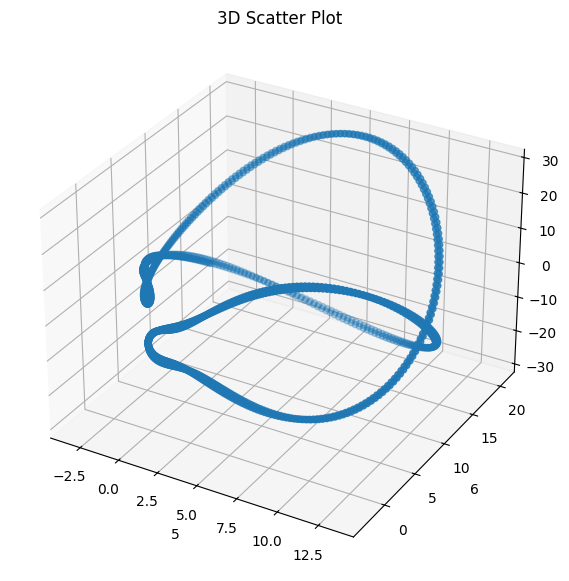

In [1651]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(24,24))
start=1000
end=2400
space = X_
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(space[start:end,0],space[start:end,1], space[start:end,2], cmap='viridis')
ax.set_xlabel('5')
ax.set_ylabel('6')
ax.set_zlabel('7')
ax.set_title('3D Scatter Plot')

plt.show()

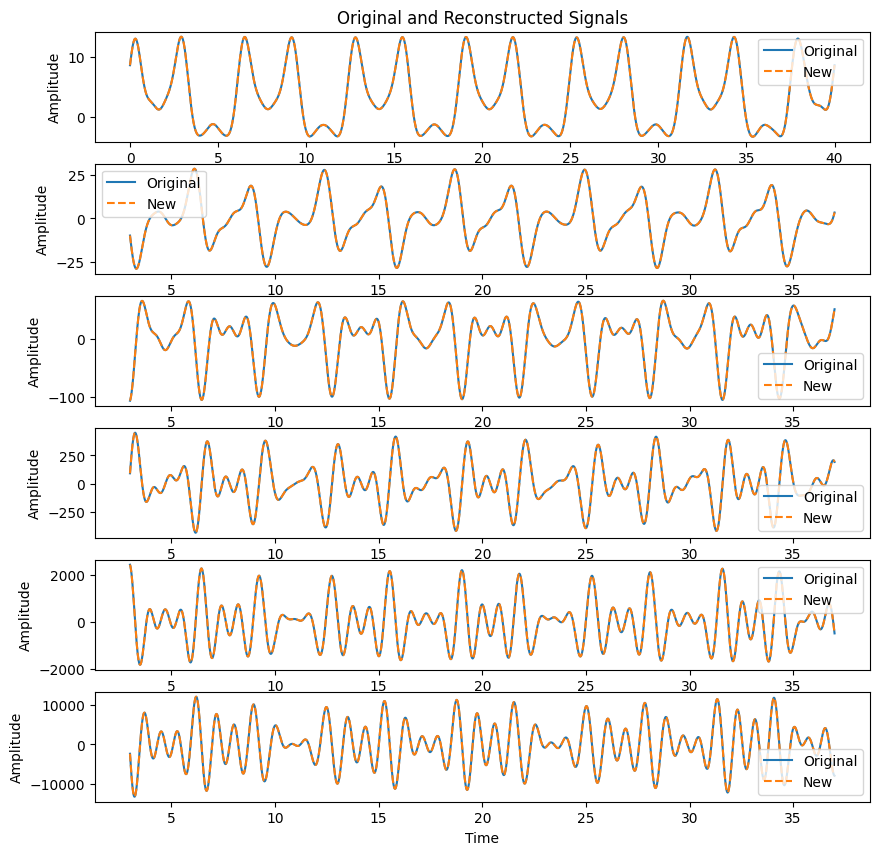

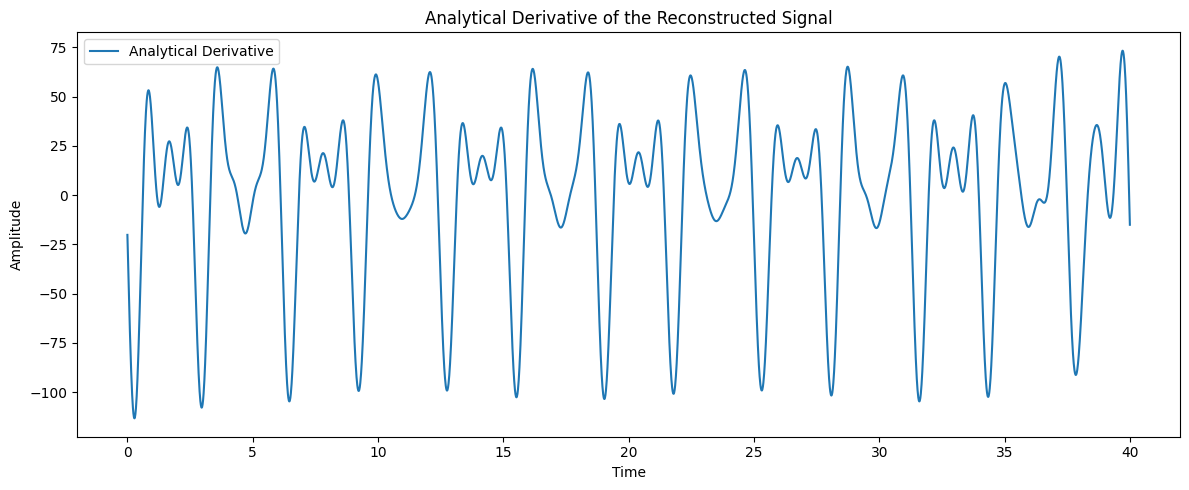

In [1653]:
plt.figure(figsize=(10, 10))
num=300
# Original and Reconstructed signal plot
plt.subplot(6, 1, 1)
plt.plot(t_large, X_[:,0], label='Original')
plt.plot(t_large, X_[:,0], label='New', linestyle='--')
plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Fourier transform plot
plt.subplot(6, 1, 2)
plt.plot(t_large[num:-num], first_deriv[num:-num,0], label='Original')
plt.plot(t_large[num:-num], X_[num:-num,2], label='New',linestyle='--')
#plt.plot(t, derivative[0], label='Analytical Derivative')
#plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(t_large[num:-num], second_deriv[num:-num,0], label='Original')
plt.plot(t_large[num:-num], X_[num:-num,4], label='New',linestyle='--')
#plt.plot(t, derivative[2], label='Analytical Derivative')
#plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Fourier transform plot
plt.subplot(6, 1, 4)
plt.plot(t_large[num:-num], third_deriv[num:-num,0], label='Original')
plt.plot(t_large[num:-num], X_[num:-num,6], label='New', linestyle='--')
#plt.plot(t, derivative[4], label='Analytical Derivative')
#plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(t_large[num:-num], fourth_deriv[num:-num,0], label='Original')
plt.plot(t_large[num:-num], X_[num:-num,8], label='New', linestyle='--')
#plt.plot(t, derivative[6], label='Analytical Derivative')
#plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Fourier transform plot
plt.subplot(6, 1, 6)
plt.plot(t_large[num:-num], fifth_deriv[num:-num,0], label='Original')
plt.plot(t_large[num:-num], X_[num:-num,10], label='New', linestyle='--')
#plt.plot(t, derivative[8], label='Analytical Derivative')
#plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(t, derivative[2], label='Analytical Derivative')
plt.title('Analytical Derivative of the Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

In [1655]:
nap = np.array([1,2,3,4,5,6])
nap[-2-1:1-1:-1], nap[1:-2]
lis_totest = np.column_stack((finite,np.array(derivative).T))

In [1717]:
ti = t
tim=1000
start=tim
end = -1000
idx = 18
#X_ = np.column_stack([finite,first_deriv_old,second_deriv_old,third_deriv_old,fourth_deriv_old, fifth_deriv_old])

# Instantiate and fit the SINDy model with the integral of u_dot
# optimizer = ps.SR3(
#     threshold=10, thresholder="l1", max_iter=50, normalize_columns=True, tol=1e-12
# )
model = ps.SINDy(differentiation_method=ps.SmoothedFiniteDifference(order=4), feature_library=ps.PolynomialLibrary(degree=1), 
         optimizer=ps.STLSQ(threshold=0.1,normalize_columns=False))

#model = ps.SINDy(feature_library=ode_lib, optimizer=ps.STLSQ(threshold=0.05,normalize_columns=False))
model.fit(X_[end-1:start-1:-1,0:idx], t=ti[1]-ti[0], ensemble=True)
model.print()

(x0)' = -1.000 x2
(x1)' = -1.000 x3
(x2)' = -1.000 x4
(x3)' = -1.000 x5
(x4)' = -1.000 x6
(x5)' = -1.000 x7
(x6)' = -1.000 x8
(x7)' = -1.000 x9
(x8)' = -1.000 x10
(x9)' = -1.000 x11
(x10)' = -1.000 x12
(x11)' = -1.000 x13
(x12)' = -0.206 1 + -1.000 x14
(x13)' = -0.892 1 + 0.108 x0 + -1.000 x15
(x14)' = -545104.590 1 + 72312.385 x0 + 46847.043 x1 + -1075.234 x2 + -824.610 x3 + 29956.237 x4 + 13810.455 x5 + -355.483 x6 + -285.603 x7 + 2965.134 x8 + 789.812 x9 + -25.603 x10 + -20.093 x11 + 97.800 x12 + 10.860 x13 + -0.459 x14 + -0.357 x15
(x15)' = -691153.192 1 + 74648.930 x0 + 67991.193 x1 + 1384.666 x2 + 1044.793 x3 + 19860.256 x4 + 28963.231 x5 + 454.397 x6 + 362.131 x7 + 1169.428 x8 + 2910.249 x9 + 32.635 x10 + 25.570 x11 + 17.417 x12 + 97.860 x13 + 0.585 x14 + 0.455 x15
(x16)' = -496399.206 1 + 57422.750 x0 + 48010.065 x1 + 73784.781 x2 + 48695.804 x3 + 18790.375 x4 + 17318.207 x5 + 30631.048 x6 + 14351.972 x7 + 1341.820 x8 + 1323.360 x9 + 3013.986 x10 + 820.018 x11 + 24.159 x12 + 28

3000


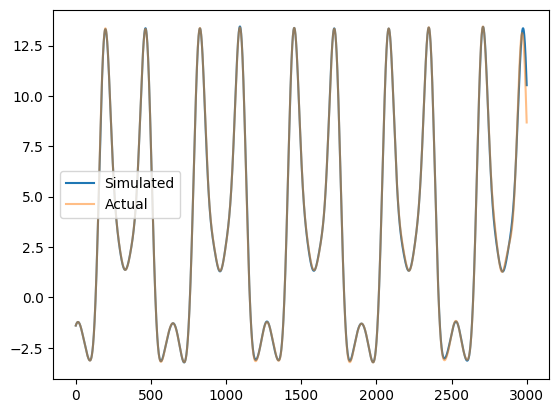

Time taken: 38.833536863327026 sec


In [1718]:
start = 1000
end = -1
import time
data = X_[::-1,0:idx]
time_start = time.time()
x_simulated = model.simulate(data[start], ti[start:], integrator_kws={'atol': 1e-12, 'method': 'RK45', 'rtol': 1e-12}, interpolator_kws={})
print(len(x_simulated))
plt.plot(x_simulated[:,0], label='Simulated')
plt.plot(data[start:,0], alpha=0.5, label='Actual')
plt.legend()
plt.show()
time_finish = time.time()
time_diff = time_finish - time_start
print("Time taken:", time_diff, "sec")

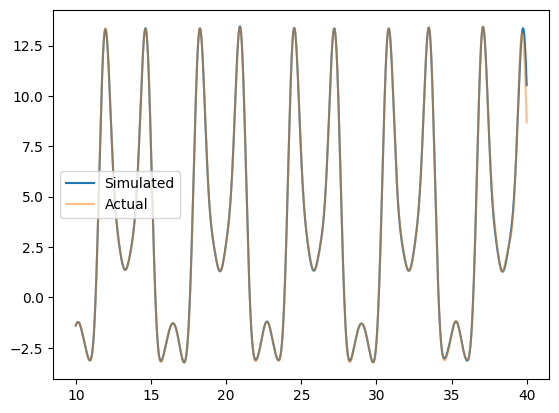

In [1719]:
plt.plot(ti[start:],x_simulated[:,0], label='Simulated')
plt.plot(ti[start:],data[start:,0], alpha=0.5, label='Actual')
plt.legend()

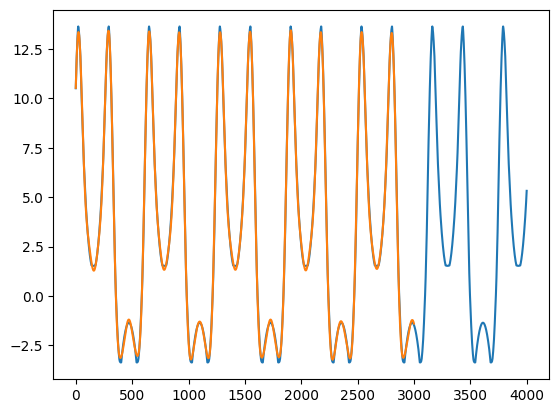

In [1720]:
plt.plot(lat_long[:,0])
plt.plot(x_simulated[::-1,0])

In [1722]:
print(x_simulated[:-2:-1,:])
print(x_deriv_lat[0,:])
model = ps.SINDy(differentiation_method=ps.SmoothedFiniteDifference(order=4), feature_library=ps.PolynomialLibrary(degree=1), 
         optimizer=ps.STLSQ(threshold=0.1,normalize_columns=False))

#model = ps.SINDy(feature_library=ode_lib, optimizer=ps.STLSQ(threshold=0.05,normalize_columns=False))
model.fit(x_simulated[::-1], t=ti[1]-ti[0], ensemble=True)
model.print()

[[ 1.05327434e+01  1.72958050e+01  2.18658465e+01 -2.64986672e+01
  -6.40914395e+01 -7.41845622e+01 -3.32790374e+02  4.11521336e+02
   9.97321927e+02  8.35699791e+02  9.22102569e+03 -1.10824248e+04
  -2.02262910e+04 -1.07433633e+04 -3.38489042e+05  3.79011631e+05
   6.27433210e+05 -1.59226819e+05]]
[ 1.05150690e+01  1.76260376e+01  2.14970556e+01 -2.74397103e+01
 -1.34168908e+02  8.55701317e+01  3.38836570e+04 -7.62909387e+04
 -1.18666799e+07  2.84084571e+07  8.62662856e+09 -3.09798708e+10
 -2.76464557e+12  1.42299323e+13  5.82515403e+14 -4.81526009e+15]
(x0)' = 1.000 x2
(x1)' = 1.000 x3
(x2)' = 1.000 x4
(x3)' = 1.000 x5
(x4)' = 1.000 x6
(x5)' = 1.000 x7
(x6)' = 1.000 x8
(x7)' = 1.000 x9
(x8)' = 1.000 x10
(x9)' = 1.000 x11
(x10)' = 1.000 x12
(x11)' = 1.000 x13
(x12)' = 0.258 1 + -0.146 x2 + 1.000 x14
(x13)' = 0.490 1 + -0.136 x3 + 1.000 x15
(x14)' = 544977.240 1 + -72296.039 x0 + -46836.115 x1 + 1074.106 x2 + 824.390 x3 + -29950.009 x4 + -13807.070 x5 + 355.211 x6 + 285.484 x7 + -2964.

4000


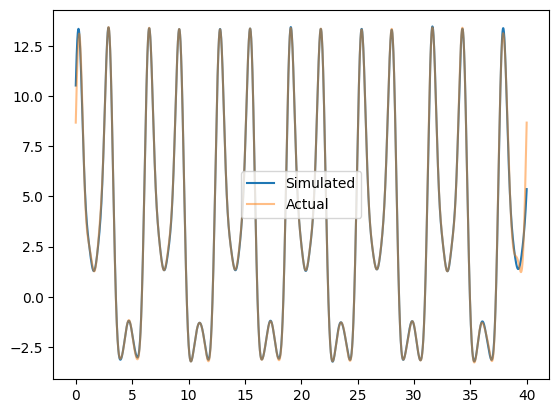

Time taken: 51.093767166137695 sec


In [1723]:
start=0
data = x_simulated[::-1]
time_start = time.time()
x_sim = model.simulate(data[start], ti[start:], integrator_kws={'atol': 1e-12, 'method': 'RK45', 'rtol': 1e-12}, interpolator_kws={})
print(len(x_sim))
plt.plot(ti[start:],x_sim[:,0], label='Simulated')
plt.plot(ti[start:],X_[start:,0], alpha=0.5, label='Actual')
plt.legend()
plt.show()
time_finish = time.time()
time_diff = time_finish - time_start
print("Time taken:", time_diff, "sec")

(3000, 18)


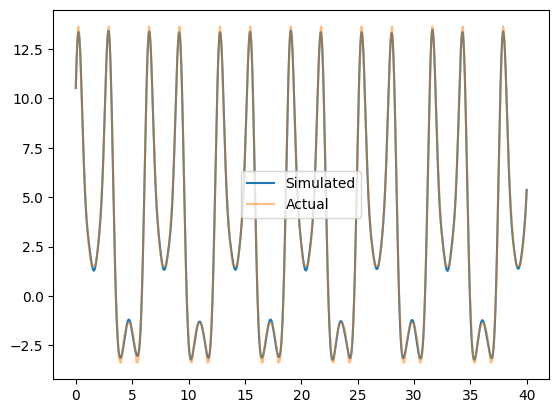

In [1724]:
plt.plot(ti[start:],x_sim[:,0], label='Simulated')
plt.plot(ti[start:],lat_long[start:,0], alpha=0.5, label='Actual')
plt.legend()
sindy_dec = autoencoder.decode(x_sim[:,0:latent.shape[1]])
print(x_simulated.shape)
auto_dec = autoencoder.decode(lat)
x = np.linspace(-10,10,2000)

(4000, 2000, 1)


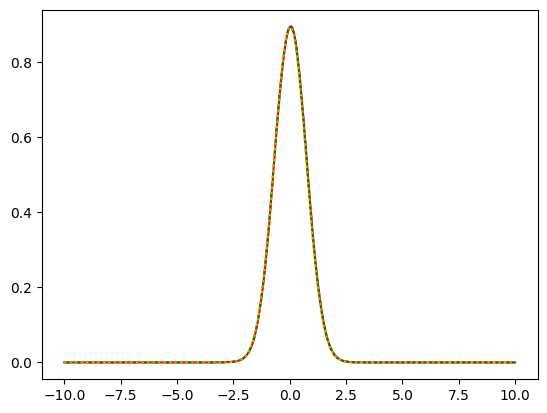

In [1725]:
plt.plot(x,sindy_dec[630], color='red')
plt.plot(x,auto_dec[630],linestyle='--', color='green')
plt.plot(x,li[630], linestyle=':', color='orange')
print(sindy_dec.shape)

0
0
400
0
0
400


0


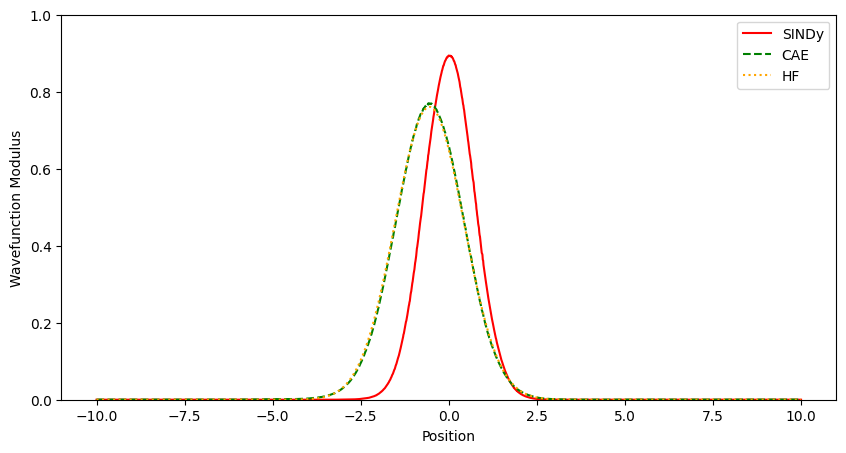

In [1726]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
def update_plot(i):
    ax.clear()
    ax.plot(x,sindy_dec[i], color='red',label='SINDy')
    ax.plot(x,auto_dec[i+1000],linestyle='--', color='green',label='CAE')
    ax.plot(x,li[i+1000], linestyle=':', color='orange',label='HF')
    ax.set_ylim([0, 1])  # Adjust the y-axis limits if necessary
    ax.set_xlabel("Position")
    ax.set_ylabel("Wavefunction Modulus")  # Adjust the ylabel to reflect the modulus
    plt.legend()
    if i % 400 == 0:
        print(i)
# Generate the animation
fig, ax = plt.subplots(figsize=(10, 5))
ani = animation.FuncAnimation(fig, update_plot, frames=800, interval=10)

# Save the animation as a video file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('wavefunction_animation.mp4', writer=writer)

# Display the animation in Jupyter Notebook
HTML(ani.to_html5_video())

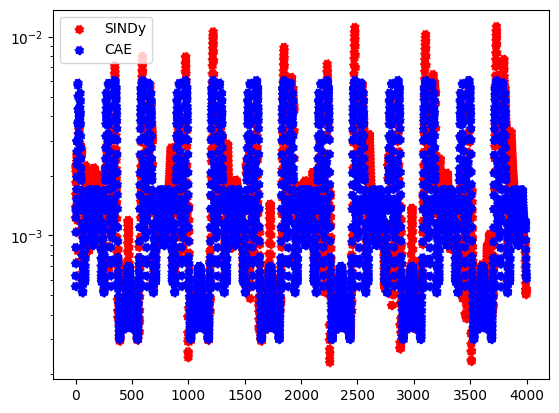

In [1727]:
for i in range(0,len(sindy_dec), 1):
    if i == 0:
        error = []
        pred_error = []
    error.append(np.array(((li[i]-sindy_dec[i])**2)*0.05).sum())
    pred_error.append(np.array(((li[i]-auto_dec[i])**2)*0.05).sum())
        
    x = np.arange(0,4000)

plt.scatter(x, error, color='red', label='SINDy', linestyle=':')
plt.scatter(x, pred_error, color='blue', label='CAE', linestyle=':')
plt.yscale('log')
plt.legend()

In [1728]:
print(np.array(error).max())

0.011258584
